# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [4]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (5000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(4986, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

99.72

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(4986, 10)


1    4178
0     808
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no 

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

Why is this $[...] when the same product is available for $[...] here? />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I'm sorry; b

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I am sorry; but these reviews do nobody any good beyond reminding us to look  before ordering.<br /><br />These are chocolate-oatmeal cookies.  If you do not like that combination, do not order this type of cookie.  I find the combo quite nice, really.  The oatmeal sort of "calms" the rich chocolate flavor and gives the cookie sort of a coconut-type consistency.  Now let is also remember that tastes differ; so, I have given my opinion.<br /><br />Then, these are soft, chewy cookies -- as advertised.  They are not "crispy" cookies, or the blurb would say "crispy," rather than "chewy."  I happen to like raw cookie dough; however, I do not see where these taste like raw cookie dough.  Both are soft, however, so is this the confusion?  And, yes, they stick together.  Soft cookies tend to do that.  They are not individually wrapped, which would add to the cost.  Oh y

In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor  and  traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Wow So far two two star reviews One obviously had no idea what they were ordering the other wants crispy cookies Hey I am sorry but these reviews do nobody any good beyond reminding us to look before ordering br br These are chocolate oatmeal cookies If you do not like that combination do not order this type of cookie I find the combo quite nice really The oatmeal sort of calms the rich chocolate flavor and gives the cookie sort of a coconut type consistency Now let is also remember that tastes differ so I have given my opinion br br Then these are soft chewy cookies as advertised They are not crispy cookies or the blurb would say crispy rather than chewy I happen to like raw cookie dough however I do not see where these taste like raw cookie dough Both are soft however so is this the confusion And yes they stick together Soft cookies tend to do that They are not individually wrapped which would add to the cost Oh yeah chocolate chip cookies tend to be somewhat sweet br br So if you wa

In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:01<00:00, 3137.37it/s]


In [23]:
preprocessed_reviews[1500]

'wow far two two star reviews one obviously no idea ordering wants crispy cookies hey sorry reviews nobody good beyond reminding us look ordering chocolate oatmeal cookies not like combination not order type cookie find combo quite nice really oatmeal sort calms rich chocolate flavor gives cookie sort coconut type consistency let also remember tastes differ given opinion soft chewy cookies advertised not crispy cookies blurb would say crispy rather chewy happen like raw cookie dough however not see taste like raw cookie dough soft however confusion yes stick together soft cookies tend not individually wrapped would add cost oh yeah chocolate chip cookies tend somewhat sweet want something hard crisp suggest nabiso ginger snaps want cookie soft chewy tastes like combination chocolate oatmeal give try place second order'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [6]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

## [4.1] BAG OF WORDS

In [25]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aahhhs', 'aback', 'abandon', 'abates', 'abbott', 'abby', 'abdominal', 'abiding', 'ability']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 12997)
the number of unique words  12997


## [4.2] Bi-Grams and n-Grams.

In [26]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.3] TF-IDF

In [27]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able find', 'able get', 'absolute', 'absolutely', 'absolutely delicious', 'absolutely love', 'absolutely no', 'according']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.4] Word2Vec

In [28]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [42]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('snack', 0.9951335191726685), ('calorie', 0.9946465492248535), ('wonderful', 0.9946032166481018), ('excellent', 0.9944332838058472), ('especially', 0.9941144585609436), ('baked', 0.9940600395202637), ('salted', 0.994047224521637), ('alternative', 0.9937226176261902), ('tasty', 0.9936816692352295), ('healthy', 0.9936649799346924)]
[('varieties', 0.9994194507598877), ('become', 0.9992934465408325), ('popcorn', 0.9992750883102417), ('de', 0.9992610216140747), ('miss', 0.9992451071739197), ('melitta', 0.999218761920929), ('choice', 0.9992102384567261), ('american', 0.9991837739944458), ('beef', 0.9991780519485474), ('finish', 0.9991567134857178)]


In [36]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  3817
sample words  ['product', 'available', 'course', 'total', 'pretty', 'stinky', 'right', 'nearby', 'used', 'ca', 'not', 'beat', 'great', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'removed', 'easily', 'daughter', 'designed', 'printed', 'use', 'car', 'windows', 'beautifully', 'shop', 'program', 'going', 'lot', 'fun', 'everywhere', 'like', 'tv', 'computer', 'really', 'good', 'idea', 'final', 'outstanding', 'window', 'everybody', 'asks', 'bought', 'made']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [38]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:03<00:00, 1330.47it/s]


4986
50


#### [4.4.1.2] TFIDF weighted W2v

In [39]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [41]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:20<00:00, 245.63it/s]


# [5] Assignment 7: SVM

<ol>
    <li><strong>Apply SVM on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Procedure</strong>
        <ul>
    <li>You need to work with 2 versions of SVM
        <ul><li>Linear kernel</li>
            <li>RBF kernel</li></ul>
    <li>When you are working with linear kernel, use SGDClassifier’ with hinge loss because it is computationally less expensive.</li>
    <li>When you are working with ‘SGDClassifier’ with hinge loss and trying to find the AUC
        score, you would have to use <a href='https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html'>CalibratedClassifierCV</a></li>
    <li>Similarly, like kdtree of knn, when you are working with RBF kernel it's better to reduce
the number of dimensions. You can put min_df = 10, max_features = 500 and consider a sample size of 40k points.</li>                
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best alpha in range [10^-4 to 10^4], and the best penalty among 'l1', 'l2')</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>When you are working on the linear kernel with BOW or TFIDF please print the top 10 best
features for each of the positive and negative classes.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying SVM

## [5.1] Linear SVM

In [1]:
#importing important libarary

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")



import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split

In [2]:
from sklearn import linear_model
from sklearn.calibration import CalibratedClassifierCV
import math

In [3]:
con = sqlite3.connect("database.sqlite")

In [45]:
amzn = pd.read_sql_query('''SELECT * 
                            FROM Reviews 
                            WHERE Score != 3 
                            ORDER BY Time''', con)

In [46]:
def partition(score):
    if score < 3:
        return 0
    else : 
        return 1
amzn_score = amzn["Score"] 
filter_amzn = amzn_score.map(partition)
amzn['Score'] = filter_amzn

In [47]:
#sorting data
sorted_data = amzn.sort_values("ProductId", axis = 0, ascending = True, \
                       inplace = False, na_position = 'last')

In [48]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [49]:
final['Score'].value_counts()

1    307063
0     57110
Name: Score, dtype: int64

In [50]:
final = final.iloc[0:100000]

In [51]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [52]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [53]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|█████████████████████████████████| 100000/100000 [03:26<00:00, 483.81it/s]


In [54]:
#splitting data into train and test
x_train = preprocessed_reviews[slice(0,70000)]
x_cv = preprocessed_reviews[slice(70000, 85000)]
x_test = preprocessed_reviews[slice(85000, 100000)]
y_train = final.iloc[:70000, 6]
y_cv = final.iloc[70000:85000, 6]
y_test = final.iloc[85000:100000, 6]

### [5.1.1] Applying Linear SVM on BOW,<font color='red'> SET 1</font>

In [55]:
# Please write all the code with proper documentation

100%|████████████████████████████████████████████| 8/8 [00:09<00:00,  1.11s/it]


l2 gives better accuracy whith difference of 1.0


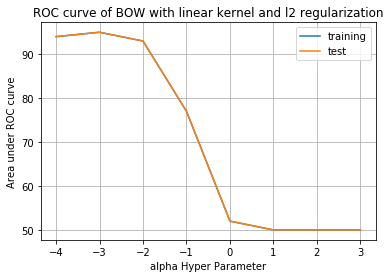

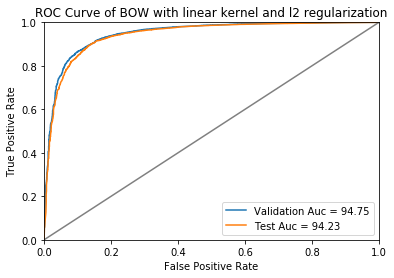

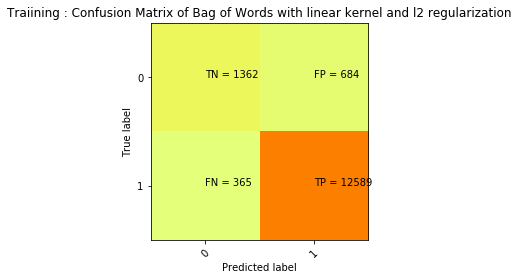

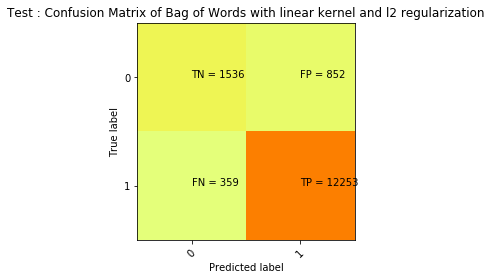

In [56]:
# Please write all the code with proper documentation
#defining function for Bag of words
def bow(para, bow_x_cv, bow_x_test):  
    count_vect = CountVectorizer() #in scikit-learn
    bow_x_train = count_vect.fit_transform(para)
    bow_x_cv = count_vect.transform(x_cv)
    bow_x_test = count_vect.transform(x_test)
    return bow_x_train, bow_x_cv, bow_x_test, count_vect



#vectorizing using above function
bow_x_train, bow_x_cv, bow_x_test, count_vect = bow(x_train, x_cv, x_test)



auc_cvl1 = []
auc_testl1 = []
alpha = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
for i in tqdm(alpha):
    # instantiate learning model (k = 30)
    clf = linear_model.SGDClassifier(loss = "hinge", penalty = "l1", alpha = i)
    bow_clfl1    = CalibratedClassifierCV(clf, method='isotonic')

    # fitting the model on crossvalidation train
    bow_clfl1.fit(bow_x_train, y_train)

    
    y_pred_proba = bow_clfl1.predict_proba(bow_x_cv)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_cv,  y_pred_proba)
    auc_cvl1.append(np.round(metrics.roc_auc_score(y_cv, y_pred_proba)*100))
    
    y_pred_proba1 = bow_clfl1.predict_proba(bow_x_test)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba1)
    auc_testl1.append(np.round(metrics.roc_auc_score(y_test, y_pred_proba1)*100))
    
    
    
    
auc_cvl2 = []
auc_testl2 = []
alpha = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
for i in tqdm(alpha):
    # instantiate learning model (k = 30)
    clf = linear_model.SGDClassifier(loss = "hinge", penalty = "l2", alpha = i)
    bow_clfl2    = CalibratedClassifierCV(clf, method='isotonic')

    # fitting the model on crossvalidation train
    bow_clfl2.fit(bow_x_train, y_train)

    
    y_pred_proba = bow_clfl2.predict_proba(bow_x_cv)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_cv,  y_pred_proba)
    auc_cvl2.append(np.round(metrics.roc_auc_score(y_cv, y_pred_proba)*100))
    
    y_pred_proba1 = bow_clfl2.predict_proba(bow_x_test)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba1)
    auc_testl2.append(np.round(metrics.roc_auc_score(y_test, y_pred_proba1)*100))
    
        
        
        
if max(auc_cvl1) > max(auc_cvl2):
    auc_cv = auc_cvl1
    auc_test = auc_cvl1
    bow_lin_opt_reg = 'l1'
    print("l1 gives better accuracy whith difference of" , max(auc_cvl1) - max(auc_cvl2))
else:
    auc_cv = auc_cvl2
    auc_test = auc_cvl2
    bow_lin_opt_reg = 'l2'
    print("l2 gives better accuracy whith difference of" , max(auc_cvl2) - max(auc_cvl1))   

    
    
    
bl_optimal_alpha = alpha[(auc_cv.index(max(auc_cv)))]



#Taking log of alpha value to print easely on graph with correcsponding auc
log_alpha = []
for i in alpha:
    log_alpha.append(math.log10(i))
log_alpha    



#printing all Auc value of corresponding k on validation and test data
df = pd.DataFrame({
                  'training': auc_cv,
                  'test': auc_test
                  }, index = log_alpha)
lines = df.plot.line()
plt.xlabel("alpha Hyper Parameter")
plt.ylabel("Area under ROC curve")
plt.title("ROC curve of BOW with linear kernel and {} regularization".format(bow_lin_opt_reg))
plt.grid()
plt.show()



clf = linear_model.SGDClassifier(loss = "hinge", penalty = bow_lin_opt_reg , alpha =bl_optimal_alpha )
bow_clf  = CalibratedClassifierCV(clf, method='isotonic')
clf.fit(bow_x_train, y_train)
bow_clf.fit(bow_x_train, y_train)



#auc curve of optimal k on validation and test data
y_predk_proba = bow_clf.predict_proba(bow_x_cv)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_cv,  y_predk_proba)
auc = np.round(metrics.roc_auc_score(y_cv, y_predk_proba)*100, 2)
bl_tr_auc = auc

plt.plot(fpr,tpr,label="Validation Auc = "+str(auc))
y_predk_proba = bow_clf.predict_proba(bow_x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_predk_proba)
auc = np.round(metrics.roc_auc_score(y_test, y_predk_proba)*100, 2)
bl_ts_auc = auc

plt.plot(fpr,tpr,label="Test Auc = "+str(auc))
plt.legend(loc=4)
plt.plot([x/10 for x in range(0, 11)],[x/10 for x in range(0, 11)], color='grey')
plt.title("ROC Curve of BOW with linear kernel and {} regularization".format(bow_lin_opt_reg))
plt.axis([0, 1, 0, 1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()



y_pred_test = bow_clf.predict(bow_x_test)
y_pred_cv = bow_clf.predict(bow_x_cv)



# http://www.tarekatwan.com/index.php/2017/12/how-to-plot-a-confusion-matrix-in-python/
cm = confusion_matrix(y_cv,y_pred_cv)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['0','1']
plt.title("Traiining : Confusion Matrix of Bag of Words with linear kernel and {} regularization".format(bow_lin_opt_reg))
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
 
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()



# http://www.tarekatwan.com/index.php/2017/12/how-to-plot-a-confusion-matrix-in-python/
cm = confusion_matrix(y_test,y_pred_test)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['0','1']
plt.title("Test : Confusion Matrix of Bag of Words with linear kernel and {} regularization".format(bow_lin_opt_reg))
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
 
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

#  Top 10 important features of positive class from BoW with Linear Kernel

In [57]:
bow_features_prob = clf.coef_

In [58]:
bow_pos_df = pd.DataFrame({'log prob': bow_features_prob[0],
                   'word': count_vect.get_feature_names()[:]
                  })
bow_pos_largest_10= bow_pos_df.nlargest(10, 'log prob')

In [59]:
from prettytable import PrettyTable
    
x = PrettyTable()
print("Top Ten features belonging to class positive or 1 of BOW ")
x.field_names = ["Top ten fetures", "Features Log Probability", "Word"]
for i in range(0, 10):
    x.add_row([i+1, bow_pos_largest_10["log prob"].values[i] ,\
               bow_pos_largest_10["word"].values[i]])

print(x)

Top Ten features belonging to class positive or 1 of BOW 
+-----------------+--------------------------+-----------+
| Top ten fetures | Features Log Probability |    Word   |
+-----------------+--------------------------+-----------+
|        1        |    0.6054084196448085    | delicious |
|        2        |    0.5797071188108313    | excellent |
|        3        |    0.5425830176061969    |    best   |
|        4        |    0.5254488170502093    |   loves   |
|        5        |    0.5168817167722181    |  perfect  |
|        6        |    0.4997475162162331    |   great   |
|        7        |   0.49689181612356853    |   highly  |
|        8        |   0.48546901575291196    |  awesome  |
|        9        |    0.4540563147336044    |  amazing  |
|        10       |    0.4483449145482777    |  pleased  |
+-----------------+--------------------------+-----------+


#  Top 10 important features of negative class from BoW with Linear Kernel

In [60]:
bow_neg_df = pd.DataFrame({'log prob': bow_features_prob[0],
                   'word': count_vect.get_feature_names()[:]
                  })
bow_neg_largest_10= bow_neg_df.nsmallest(10, 'log prob')


In [61]:
from prettytable import PrettyTable
    
x = PrettyTable()
print("Top Ten features belonging to class negative or 0 of BOW")
x.field_names = ["Top ten fetures", "Features Log Probability", "Word"]
for i in range(0, 10):
    x.add_row([i+1, bow_neg_largest_10["log prob"].values[i] , \
                    bow_neg_largest_10["word"].values[i]])

print(x)

Top Ten features belonging to class negative or 0 of BOW
+-----------------+--------------------------+----------------+
| Top ten fetures | Features Log Probability |      Word      |
+-----------------+--------------------------+----------------+
|        1        |   -1.0137735328957866    |     worst      |
|        2        |   -0.9138240296525417    | disappointing  |
|        3        |   -0.8338644270579456    |    terrible    |
|        4        |   -0.7367706239073605    |  disappointed  |
|        5        |   -0.7310592237220321    |     awful      |
|        6        |   -0.7196364233513761    | disappointment |
|        7        |    -0.711069323073384    |     threw      |
|        8        |   -0.6453882209421067    |    horrible    |
|        9        |   -0.6111198198301354    | unfortunately  |
|        10       |   -0.5797071188108304    |     money      |
+-----------------+--------------------------+----------------+


### [5.1.2] Applying Linear SVM on TFIDF,<font color='red'> SET 2</font>

In [62]:
# Please write all the code with proper documentation

100%|████████████████████████████████████████████| 8/8 [00:12<00:00,  1.53s/it]


l2 gives better accuracy whith difference of 1.0


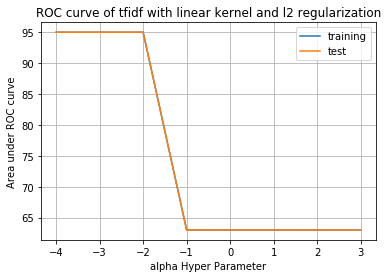

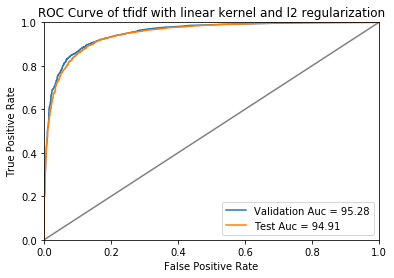

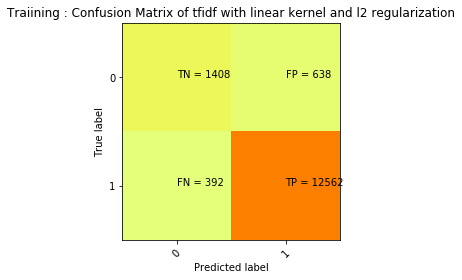

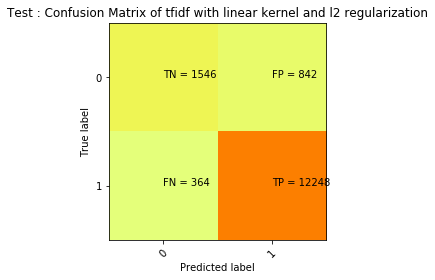

In [63]:
def tfidf(preprocessed_reviews, x_cv, x_test):
    tf_idf_vect = TfidfVectorizer()
    vectorizer = tf_idf_vect.fit_transform(preprocessed_reviews)
    tfidf_x_cv = tf_idf_vect.transform(x_cv)
    tfidf_x_test = tf_idf_vect.transform(x_test)
    return vectorizer, tfidf_x_cv, tfidf_x_test, tf_idf_vect


tfidf_x_train, tfidf_x_cv, tfidf_x_test, tfidf_vect = tfidf(x_train, x_cv, x_test)



auc_cvl1 = []
auc_testl1 = []
alpha = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
for i in tqdm(alpha):
    # instantiate learning model (k = 30)
    clf = linear_model.SGDClassifier(loss = "hinge", penalty = "l1", alpha = i)
    tfidf_clfl1    = CalibratedClassifierCV(clf, method='isotonic')

    # fitting the model on crossvalidation train
    tfidf_clfl1.fit(tfidf_x_train, y_train)

    
    y_pred_proba = tfidf_clfl1.predict_proba(tfidf_x_cv)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_cv,  y_pred_proba)
    auc_cvl1.append(np.round(metrics.roc_auc_score(y_cv, y_pred_proba)*100))
    
    y_pred_proba1 = tfidf_clfl1.predict_proba(tfidf_x_test)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba1)
    auc_testl1.append(np.round(metrics.roc_auc_score(y_test, y_pred_proba1)*100))

    
    

auc_cvl2 = []
auc_testl2 = []
alpha = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
for i in tqdm(alpha):
    # instantiate learning model (k = 30)
    clf = linear_model.SGDClassifier(loss = "hinge", penalty = "l2", alpha = i)
    tfidf_clfl2    = CalibratedClassifierCV(clf, method='isotonic')

    # fitting the model on crossvalidation train
    tfidf_clfl2.fit(tfidf_x_train, y_train)

    
    y_pred_proba = tfidf_clfl2.predict_proba(tfidf_x_cv)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_cv,  y_pred_proba)
    auc_cvl2.append(np.round(metrics.roc_auc_score(y_cv, y_pred_proba)*100))
    
    y_pred_proba1 = tfidf_clfl2.predict_proba(tfidf_x_test)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba1)
    auc_testl2.append(np.round(metrics.roc_auc_score(y_test, y_pred_proba1)*100))
    
        


if max(auc_cvl1) > max(auc_cvl2):
    auc_cv = auc_cvl1
    auc_test = auc_cvl1
    tfidf_lin_opt_reg = 'l1'
    print("l1 gives better accuracy whith difference of" , max(auc_cvl1) - max(auc_cvl2))
else:
    auc_cv = auc_cvl2
    auc_test = auc_cvl2
    tfidf_lin_opt_reg = 'l2'
    print("l2 gives better accuracy whith difference of" , max(auc_cvl2) - max(auc_cvl1))  
    
    
    
    
tl_optimal_alpha = alpha[(auc_cv.index(max(auc_cv)))]    

#Taking log of alpha value to print easely on graph with correcsponding auc
log_alpha = []
for i in alpha:
    log_alpha.append(math.log10(i))
log_alpha    



#printing all Auc value of corresponding k on validation and test data
df = pd.DataFrame({
                  'training': auc_cv,
                  'test': auc_test
                  }, index = log_alpha)
lines = df.plot.line()
plt.xlabel("alpha Hyper Parameter")
plt.ylabel("Area under ROC curve")
plt.title("ROC curve of tfidf with linear kernel and {} regularization".format(tfidf_lin_opt_reg))
plt.grid()
plt.show()



clf = linear_model.SGDClassifier(loss = "hinge", penalty = tfidf_lin_opt_reg , alpha = tl_optimal_alpha )
tfidf_clf  = CalibratedClassifierCV(clf, method='isotonic')
clf.fit(tfidf_x_train, y_train)
tfidf_clf.fit(tfidf_x_train, y_train)



#auc curve of optimal k on validation and test data
y_predk_proba = tfidf_clf.predict_proba(tfidf_x_cv)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_cv,  y_predk_proba)
auc = np.round(metrics.roc_auc_score(y_cv, y_predk_proba)*100, 2)
tl_tr_auc = auc

plt.plot(fpr,tpr,label="Validation Auc = "+str(auc))
y_predk_proba = tfidf_clf.predict_proba(tfidf_x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_predk_proba)
auc = np.round(metrics.roc_auc_score(y_test, y_predk_proba)*100, 2)
tl_ts_auc = auc

plt.plot(fpr,tpr,label="Test Auc = "+str(auc))
plt.legend(loc=4)
plt.plot([x/10 for x in range(0, 11)],[x/10 for x in range(0, 11)], color='grey')
plt.title("ROC Curve of tfidf with linear kernel and {} regularization".format(tfidf_lin_opt_reg))
plt.axis([0, 1, 0, 1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()



y_pred_test = tfidf_clf.predict(tfidf_x_test)
y_pred_cv = tfidf_clf.predict(tfidf_x_cv)



# http://www.tarekatwan.com/index.php/2017/12/how-to-plot-a-confusion-matrix-in-python/
cm = confusion_matrix(y_cv,y_pred_cv)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['0','1']
plt.title("Traiining : Confusion Matrix of tfidf with linear kernel and {} regularization".format(tfidf_lin_opt_reg))
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
 
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()



# http://www.tarekatwan.com/index.php/2017/12/how-to-plot-a-confusion-matrix-in-python/
cm = confusion_matrix(y_test,y_pred_test)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['0','1']
plt.title("Test : Confusion Matrix of tfidf with linear kernel and {} regularization".format(tfidf_lin_opt_reg))
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
 
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

# Top 10 important features of positive class from TFIDF with Linear Kernel

In [64]:
tfidf_features_prob = clf.coef_

In [65]:
tfidf_pos_df = pd.DataFrame({'log prob': tfidf_features_prob[0],
                   'word': tfidf_vect.get_feature_names()[:]
                  })
tfidf_pos_largest_10= tfidf_pos_df.nlargest(10, 'log prob')


In [66]:
from prettytable import PrettyTable
    
x = PrettyTable()
print("Top Ten features belonging to class positive or 1 of tfidf")
x.field_names = ["Top ten fetures", "Features Log Probability", "Word"]
for i in range(0, 10):
    x.add_row([i+1, tfidf_pos_largest_10["log prob"].values[i] ,\
               tfidf_pos_largest_10["word"].values[i]])

print(x)

Top Ten features belonging to class positive or 1 of tfidf
+-----------------+--------------------------+-----------+
| Top ten fetures | Features Log Probability |    Word   |
+-----------------+--------------------------+-----------+
|        1        |    3.7320859313023615    |   great   |
|        2        |    3.104394916768576     |    best   |
|        3        |    2.6341865343691913    | delicious |
|        4        |    2.2594036059066642    |    love   |
|        5        |    2.2409881607138935    | excellent |
|        6        |    2.2144076236499037    |   loves   |
|        7        |    2.205968184455521     |    good   |
|        8        |    2.121345657661638     |  perfect  |
|        9        |    1.9406062542126894    | wonderful |
|        10       |    1.7573178983482987    |    nice   |
+-----------------+--------------------------+-----------+


# Top 10 important features of negative class from TFIDF with Linear Kernel

In [67]:
tfidf_neg_df = pd.DataFrame({'log prob': tfidf_features_prob[0],
                   'word': tfidf_vect.get_feature_names()[:]
                  })
tfidf_neg_largest_10= tfidf_neg_df.nsmallest(10, 'log prob')


In [68]:
from prettytable import PrettyTable
    
x = PrettyTable()
print("Top Ten features belonging to class negative or 0 of tfidf")
x.field_names = ["Top ten fetures", "Features Log Probability", "Word"]
for i in range(0, 10):
    x.add_row([i+1, tfidf_neg_largest_10["log prob"].values[i] , \
                    tfidf_neg_largest_10["word"].values[i]])

print(x)

Top Ten features belonging to class negative or 0 of tfidf
+-----------------+--------------------------+----------------+
| Top ten fetures | Features Log Probability |      Word      |
+-----------------+--------------------------+----------------+
|        1        |    -3.764755822910777    |     worst      |
|        2        |   -3.2988007294332817    |  disappointed  |
|        3        |    -3.238896351520117    |      not       |
|        4        |    -3.218849765733173    |    terrible    |
|        5        |    -3.012936822705141    |     threw      |
|        6        |   -2.9550734830136656    |     awful      |
|        7        |    -2.87494671183764     | disappointing  |
|        8        |   -2.7588520319463767    |    horrible    |
|        9        |    -2.620257828222368    |     money      |
|        10       |    -2.519404802859417    | disappointment |
+-----------------+--------------------------+----------------+


### [5.1.3]  Applying Linear SVM on AVG W2V,<font color='red'> SET 3</font>

In [69]:
# Please write all the code with proper documentation

100%|████████████████████████████████████████████| 8/8 [00:10<00:00,  1.33s/it]


l2 gives better accuracy whith difference of 0.0


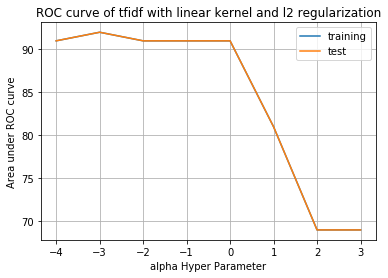

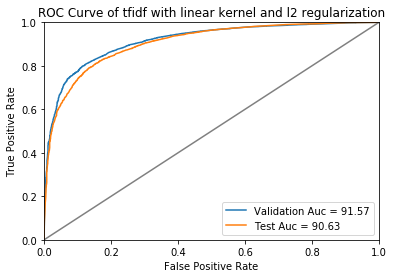

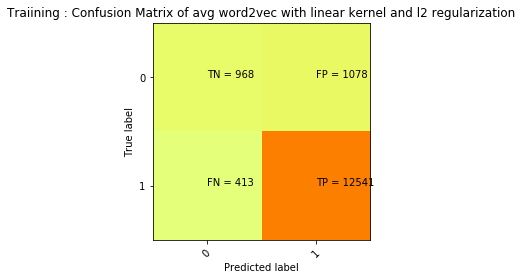

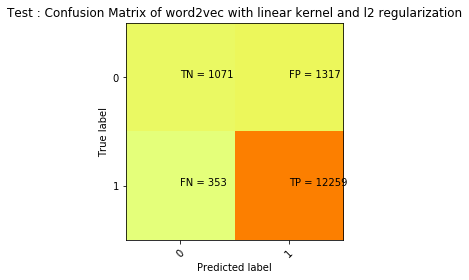

In [70]:
# Please write all the code with proper documentation
def avg_w2v(preprocessed_reviews, x, w2v_model):
    i=0
    list_of_sentance=[]
    for sentance in preprocessed_reviews:
        list_of_sentance.append(sentance.split())
                            
    is_your_ram_gt_16g=False
    want_to_use_google_w2v = False
    want_to_train_w2v = True
    if 1 == x:
        if want_to_train_w2v:
            # min_count = 5 considers only words that occured atleast 5 times
            w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
        elif want_to_use_google_w2v and is_your_ram_gt_16g:
            if os.path.isfile('GoogleNews-vectors-negative300.bin'):
                w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
                print(w2v_model.wv.most_similar('great'))
                print(w2v_model.wv.most_similar('worst'))
        else:
            print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

    w2v_words = list(w2v_model.wv.vocab)                      

    # average Word2Vec
    # compute average word2vec for each review.
    sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in tqdm(list_of_sentance): # for each review/sentence
        sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vectors.append(sent_vec) 
    
    return sent_vectors, list_of_sentance, w2v_model                          


#vectorizing using above function
avg_w2v_x_train, los_train, w2v_model = avg_w2v(x_train, 1, None)
avg_w2v_x_cv, los_cv, w2v_model = avg_w2v(x_cv, 0, w2v_model)
avg_w2v_x_test, los_test, w2v_model = avg_w2v(x_test, 0, w2v_model)



auc_cvl1 = []
auc_testl1 = []
alpha = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
for i in tqdm(alpha):
    # instantiate learning model (k = 30)
    svm = linear_model.SGDClassifier(loss = "hinge", penalty = "l1", alpha = i)
    clfl1    = CalibratedClassifierCV(svm, method='isotonic')

    # fitting the model on crossvalidation train
    clfl1.fit(avg_w2v_x_train, y_train)

    
    y_pred_proba = clfl1.predict_proba(avg_w2v_x_cv)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_cv,  y_pred_proba)
    auc_cvl1.append(np.round(metrics.roc_auc_score(y_cv, y_pred_proba)*100))
    
    y_pred_proba1 = clfl1.predict_proba(avg_w2v_x_test)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba1)
    auc_testl1.append(np.round(metrics.roc_auc_score(y_test, y_pred_proba1)*100))
    

    
auc_cvl2 = []
auc_testl2 = []
alpha = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
for i in tqdm(alpha):
    # instantiate learning model (k = 30)
    svm = linear_model.SGDClassifier(loss = "hinge", penalty = "l2", alpha = i)
    clfl2    = CalibratedClassifierCV(svm, method='isotonic')

    # fitting the model on crossvalidation train
    clfl2.fit(avg_w2v_x_train, y_train)

    
    y_pred_proba = clfl2.predict_proba(avg_w2v_x_cv)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_cv,  y_pred_proba)
    auc_cvl2.append(np.round(metrics.roc_auc_score(y_cv, y_pred_proba)*100))
    
    y_pred_proba1 = clfl2.predict_proba(avg_w2v_x_test)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba1)
    auc_testl2.append(np.round(metrics.roc_auc_score(y_test, y_pred_proba1)*100))

    
    
if max(auc_cvl1) > max(auc_cvl2):
    auc_cv = auc_cvl1
    auc_test = auc_cvl1
    avg_w2v_lin_opt_reg = 'l1'
    print("l1 gives better accuracy whith difference of" , max(auc_cvl1) - max(auc_cvl2))
else:
    auc_cv = auc_cvl2
    auc_test = auc_cvl2
    avg_w2v_lin_opt_reg = 'l2'
    print("l2 gives better accuracy whith difference of" , max(auc_cvl2) - max(auc_cvl1))  
    
    
    
awl_optimal_alpha = alpha[(auc_cv.index(max(auc_cv)))]



#printing all Auc value of corresponding k on validation and test data
df = pd.DataFrame({
                  'training': auc_cv,
                  'test': auc_test
                  }, index = log_alpha)
lines = df.plot.line()
plt.xlabel("alpha Hyper Parameter")
plt.ylabel("Area under ROC curve")
plt.title("ROC curve of tfidf with linear kernel and {} regularization".format(avg_w2v_lin_opt_reg))
plt.grid()
plt.show()



svm = linear_model.SGDClassifier(loss = "hinge", penalty = avg_w2v_lin_opt_reg , alpha = awl_optimal_alpha )
clf  = CalibratedClassifierCV(svm, method='isotonic')
clf.fit(avg_w2v_x_train, y_train)



#auc curve of optimal k on validation and test data
y_predk_proba = clf.predict_proba(avg_w2v_x_cv)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_cv,  y_predk_proba)
auc = np.round(metrics.roc_auc_score(y_cv, y_predk_proba)*100, 2)
awl_tr_auc = auc

plt.plot(fpr,tpr,label="Validation Auc = "+str(auc))
y_predk_proba = clf.predict_proba(avg_w2v_x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_predk_proba)
auc = np.round(metrics.roc_auc_score(y_test, y_predk_proba)*100, 2)
awl_ts_auc = auc

plt.plot(fpr,tpr,label="Test Auc = "+str(auc))
plt.legend(loc=4)
plt.plot([x/10 for x in range(0, 11)],[x/10 for x in range(0, 11)], color='grey')
plt.title("ROC Curve of tfidf with linear kernel and {} regularization".format(avg_w2v_lin_opt_reg))
plt.axis([0, 1, 0, 1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()



y_pred_test = clf.predict(avg_w2v_x_test)
y_pred_cv = clf.predict(avg_w2v_x_cv)



# http://www.tarekatwan.com/index.php/2017/12/how-to-plot-a-confusion-matrix-in-python/
cm = confusion_matrix(y_cv,y_pred_cv)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['0','1']
plt.title("Traiining : Confusion Matrix of avg word2vec with linear kernel and {} regularization".format(avg_w2v_lin_opt_reg))
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
 
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()



# http://www.tarekatwan.com/index.php/2017/12/how-to-plot-a-confusion-matrix-in-python/
cm = confusion_matrix(y_test,y_pred_test)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['0','1']
plt.title("Test : Confusion Matrix of word2vec with linear kernel and {} regularization".format(avg_w2v_lin_opt_reg))
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
 
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

### [5.1.4]  Applying Linear SVM on TFIDF W2V,<font color='red'> SET 4</font>

In [71]:
# Please write all the code with proper documentation

100%|████████████████████████████████████████████| 8/8 [00:11<00:00,  1.52s/it]


l2 gives better accuracy whith difference of 0.0


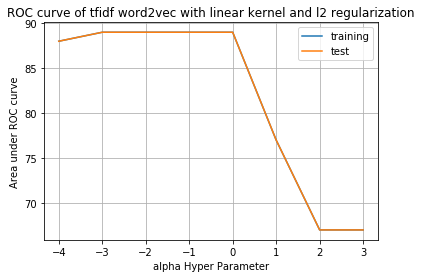

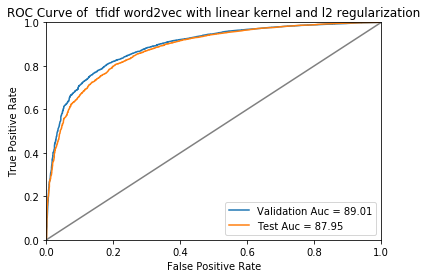

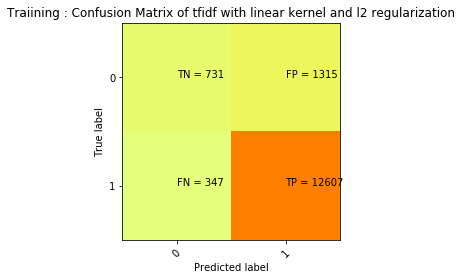

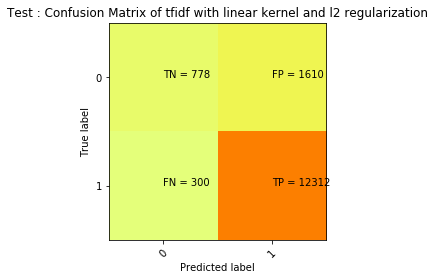

In [72]:
def tfidf_w2v(preprocessed_reviews, list_of_sentance, w2v_model, w2v_words, x, model):
    if 1 == x:
        model = TfidfVectorizer()
        tf_idf_matrix = model.fit_transform(preprocessed_reviews)
        # we are converting a dictionary with word as a key, and the idf as a value
        dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))
        # TF-IDF weighted Word2Vec
        tfidf_feat = model.get_feature_names() # tfidf words/col-names
        # final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf
    else: 
        tf_idf_matrix = model.transform(preprocessed_reviews)
        dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))
        tfidf_feat = model.get_feature_names()
        
    tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
    row=0;
    for sent in tqdm(list_of_sentance): # for each review/sentence 
        sent_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words and word in tfidf_feat:
                vec = w2v_model.wv[word]
                # tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
                # to reduce the computation we are  
                # dictionary[word] = idf value of word in whole courpus
                # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
        row += 1
    return tfidf_sent_vectors, model               


#vectorizing using above function
tfidf_w2v_x_train, model = tfidf_w2v(x_train, los_train, w2v_model, list(w2v_model.wv.vocab), 1, None)
tfidf_w2v_x_cv, model = tfidf_w2v(x_cv, los_cv, w2v_model, list(w2v_model.wv.vocab), 0, model)
tfidf_w2v_x_test, model = tfidf_w2v(x_test, los_test, w2v_model, list(w2v_model.wv.vocab), 0, model)


auc_cvl1 = []
auc_testl1 = []
for i in tqdm(alpha):
    # instantiate learning model (k = 30)
    svm = linear_model.SGDClassifier(loss = "hinge", penalty = "l1", alpha = i)
    clfl1    = CalibratedClassifierCV(svm, method='isotonic')
    # fitting the model on crossvalidation train
    clfl1.fit(tfidf_w2v_x_train, y_train)

    # predict the response on the crossvalidation train
    pred_cv = clfl1.predict(tfidf_w2v_x_train)
    
    y_pred_proba = clfl1.predict_proba(tfidf_w2v_x_cv)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_cv,  y_pred_proba)
    auc_cvl1.append(np.round(metrics.roc_auc_score(y_cv, y_pred_proba)*100))
    
    y_pred_proba1 = clfl1.predict_proba(tfidf_w2v_x_test)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba1)
    auc_testl1.append(np.round(metrics.roc_auc_score(y_test, y_pred_proba1)*100))


auc_cvl2 = []
auc_testl2 = []
for i in tqdm(alpha):
    # instantiate learning model (k = 30)
    svm = linear_model.SGDClassifier(loss = "hinge", penalty = "l2", alpha = i)
    clfl2    = CalibratedClassifierCV(svm, method='isotonic')
    # fitting the model on crossvalidation train
    clfl2.fit(tfidf_w2v_x_train, y_train)

    # predict the response on the crossvalidation train
    pred_cv = clfl2.predict(tfidf_w2v_x_train)
    
    y_pred_proba = clfl2.predict_proba(tfidf_w2v_x_cv)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_cv,  y_pred_proba)
    auc_cvl2.append(np.round(metrics.roc_auc_score(y_cv, y_pred_proba)*100))
    
    y_pred_proba1 = clfl2.predict_proba(tfidf_w2v_x_test)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba1)
    auc_testl2.append(np.round(metrics.roc_auc_score(y_test, y_pred_proba1)*100))
    
    
    
    
if max(auc_cvl1) > max(auc_cvl2):
    auc_cv = auc_cvl1
    auc_test = auc_cvl1
    tw2v_lin_opt_reg = 'l1'
    print("l1 gives better accuracy whith difference of" , max(auc_cvl1) - max(auc_cvl2))
else:
    auc_cv = auc_cvl2
    auc_test = auc_cvl2
    tw2v_lin_opt_reg = 'l2'
    print("l2 gives better accuracy whith difference of" , max(auc_cvl2) - max(auc_cvl1))  
    
    

twl_optimal_alpha = alpha[(auc_cv.index(max(auc_cv)))]    


#printing all Auc value of corresponding k on validation and test data
df = pd.DataFrame({
                  'training': auc_cv,
                  'test': auc_test
                  }, index = log_alpha)
lines = df.plot.line()
plt.xlabel("alpha Hyper Parameter")
plt.ylabel("Area under ROC curve")
plt.title("ROC curve of tfidf word2vec with linear kernel and {} regularization".format(tw2v_lin_opt_reg))
plt.grid()
plt.show()


svm = linear_model.SGDClassifier(loss = "hinge", penalty = tw2v_lin_opt_reg , alpha =twl_optimal_alpha )
clf  = CalibratedClassifierCV(svm, method='isotonic')
clf.fit(tfidf_w2v_x_train, y_train)



#auc curve of optimal k on validation and test data
y_predk_proba = clf.predict_proba(tfidf_w2v_x_cv)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_cv,  y_predk_proba)
auc = np.round(metrics.roc_auc_score(y_cv, y_predk_proba)*100, 2)
twl_tr_auc = auc
plt.plot(fpr,tpr,label="Validation Auc = "+str(auc))

y_predk_proba = clf.predict_proba(tfidf_w2v_x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_predk_proba)
auc = np.round(metrics.roc_auc_score(y_test, y_predk_proba)*100, 2)
twl_ts_auc = auc
plt.plot(fpr,tpr,label="Test Auc = "+str(auc))

plt.legend(loc=4)
plt.plot([x/10 for x in range(0, 11)],[x/10 for x in range(0, 11)], color='grey')
plt.title("ROC Curve of  tfidf word2vec with linear kernel and {} regularization".format(tw2v_lin_opt_reg))
plt.axis([0, 1, 0, 1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()



y_pred_test = clf.predict(tfidf_w2v_x_test)
y_pred_cv = clf.predict(tfidf_w2v_x_cv)



# http://www.tarekatwan.com/index.php/2017/12/how-to-plot-a-confusion-matrix-in-python/
cm = confusion_matrix(y_cv,y_pred_cv)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['0','1']
plt.title("Traiining : Confusion Matrix of tfidf with linear kernel and {} regularization".format(tw2v_lin_opt_reg))
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
 
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()



# http://www.tarekatwan.com/index.php/2017/12/how-to-plot-a-confusion-matrix-in-python/
cm = confusion_matrix(y_test,y_pred_test)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['0','1']
plt.title("Test : Confusion Matrix of tfidf with linear kernel and {} regularization".format(tw2v_lin_opt_reg))
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
 
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

## [5.2] RBF SVM

In [73]:
#splitting data into train and test
x_train = preprocessed_reviews[slice(0,12000)]
x_cv = preprocessed_reviews[slice(12000, 16000)]
x_test = preprocessed_reviews[slice(16000, 20000)]
y_train = final.iloc[:12000, 6]
y_cv = final.iloc[12000:16000, 6]
y_test = final.iloc[16000:20000, 6]


In [74]:
from sklearn.svm import SVC

### [5.2.1] Applying RBF SVM on BOW,<font color='red'> SET 1</font>

In [75]:
85025 + 19010011

19095036

In [76]:
# Please write all the code with proper documentation

100%|███████████████████████████████████████████| 8/8 [16:17<00:00, 130.29s/it]


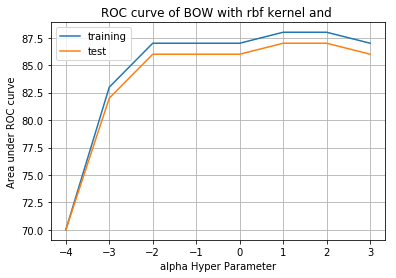

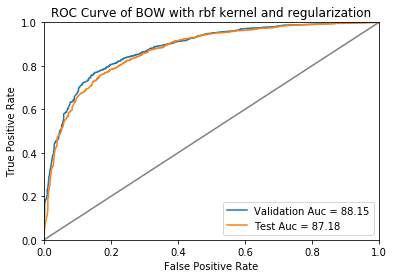

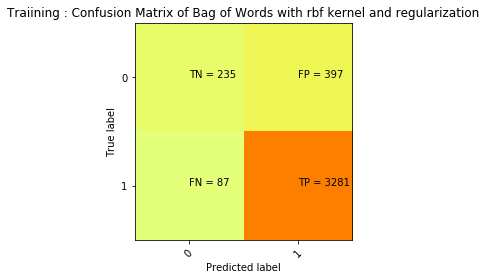

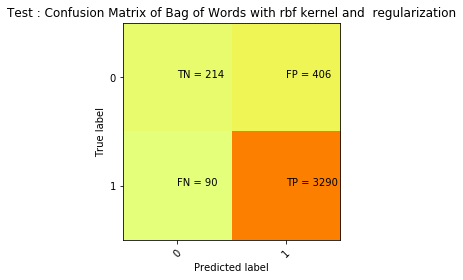

In [77]:
# Please write all the code with proper documentation
#defining function for Bag of words
def bow(para, bow_x_cv, bow_x_test):  
    count_vect = CountVectorizer(min_df = 10, max_features = 500) #in scikit-learn
    bow_x_train = count_vect.fit_transform(para)
    bow_x_cv = count_vect.transform(x_cv)
    bow_x_test = count_vect.transform(x_test)
    return bow_x_train, bow_x_cv, bow_x_test



#vectorizing using above function
bow_x_train, bow_x_cv, bow_x_test = bow(x_train, x_cv, x_test)



auc_cv = []
auc_test = []
alpha = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
for i in tqdm(alpha):
    # instantiate learning model (k = 30)
    svc =  SVC(kernel='rbf', C = i)
    clf =  CalibratedClassifierCV(svc, method='isotonic')
    
    
    # fitting the model on crossvalidation train
    clf.fit(bow_x_train, y_train)

    
    y_pred_proba = clf.predict_proba(bow_x_cv)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_cv,  y_pred_proba)
    auc_cv.append(np.round(metrics.roc_auc_score(y_cv, y_pred_proba)*100))
    
    y_pred_proba1 = clf.predict_proba(bow_x_test)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba1)
    auc_test.append(np.round(metrics.roc_auc_score(y_test, y_pred_proba1)*100))
    
    
    
    
br_optimal_alpha = alpha[(auc_cv.index(max(auc_cv)))]



#Taking log of alpha value to print easely on graph with correcsponding auc
log_alpha = []
for i in alpha:
    log_alpha.append(math.log10(i))
log_alpha    



#printing all Auc value of corresponding k on validation and test data
df = pd.DataFrame({
                  'training': auc_cv,
                  'test': auc_test
                  }, index = log_alpha)
lines = df.plot.line()
plt.xlabel("alpha Hyper Parameter")
plt.ylabel("Area under ROC curve")
plt.title("ROC curve of BOW with rbf kernel and ")
plt.grid()
plt.show()



clf = SVC(kernel ="rbf" , C = br_optimal_alpha )
bow_clf  = CalibratedClassifierCV(clf, method='isotonic')
bow_clf.fit(bow_x_train, y_train)



#auc curve of optimal k on validation and test data
y_predk_proba = bow_clf.predict_proba(bow_x_cv)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_cv,  y_predk_proba)
auc = np.round(metrics.roc_auc_score(y_cv, y_predk_proba)*100, 2)
br_tr_auc = auc

plt.plot(fpr,tpr,label="Validation Auc = "+str(auc))
y_predk_proba = bow_clf.predict_proba(bow_x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_predk_proba)
auc = np.round(metrics.roc_auc_score(y_test, y_predk_proba)*100, 2)
br_ts_auc = auc

plt.plot(fpr,tpr,label="Test Auc = "+str(auc))
plt.legend(loc=4)
plt.plot([x/10 for x in range(0, 11)],[x/10 for x in range(0, 11)], color='grey')
plt.title("ROC Curve of BOW with rbf kernel and regularization")
plt.axis([0, 1, 0, 1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()



y_pred_test = bow_clf.predict(bow_x_test)
y_pred_cv = bow_clf.predict(bow_x_cv)



# http://www.tarekatwan.com/index.php/2017/12/how-to-plot-a-confusion-matrix-in-python/
cm = confusion_matrix(y_cv,y_pred_cv)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['0','1']
plt.title("Traiining : Confusion Matrix of Bag of Words with rbf kernel and regularization")
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
 
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()



# http://www.tarekatwan.com/index.php/2017/12/how-to-plot-a-confusion-matrix-in-python/
cm = confusion_matrix(y_test,y_pred_test)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['0','1']
plt.title("Test : Confusion Matrix of Bag of Words with rbf kernel and  regularization")
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
 
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

### [5.2.2] Applying RBF SVM on TFIDF,<font color='red'> SET 2</font>

In [78]:
# Please write all the code with proper documentation

100%|███████████████████████████████████████████| 8/8 [26:43<00:00, 218.52s/it]


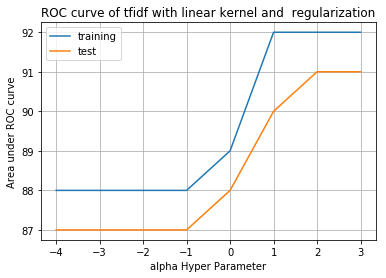

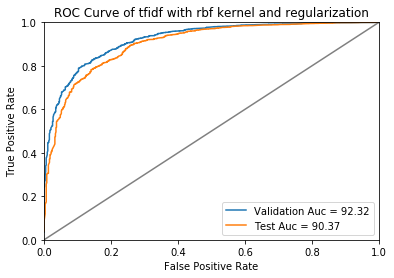

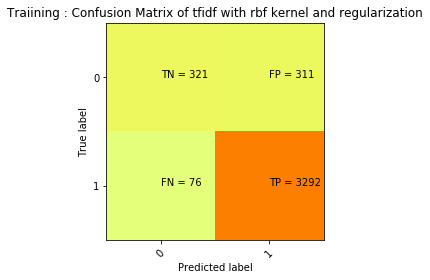

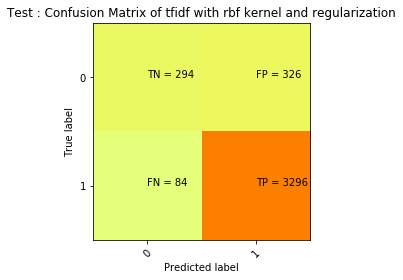

In [79]:
def tfidf(preprocessed_reviews, x_cv, x_test):
    tf_idf_vect = TfidfVectorizer()
    vectorizer = tf_idf_vect.fit_transform(preprocessed_reviews)
    tfidf_x_cv = tf_idf_vect.transform(x_cv)
    tfidf_x_test = tf_idf_vect.transform(x_test)
    return vectorizer, tfidf_x_cv, tfidf_x_test


tfidf_x_train, tfidf_x_cv, tfidf_x_test = tfidf(x_train, x_cv, x_test)



auc_cv = []
auc_test = []
alpha = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
for i in tqdm(alpha):
    # instantiate learning model (k = 30)
    clf = SVC(kernel = 'rbf', C = i)
    tfidf_clf    = CalibratedClassifierCV(clf, method='isotonic')

    # fitting the model on crossvalidation train
    tfidf_clf.fit(tfidf_x_train, y_train)

    
    y_pred_proba = tfidf_clf.predict_proba(tfidf_x_cv)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_cv,  y_pred_proba)
    auc_cv.append(np.round(metrics.roc_auc_score(y_cv, y_pred_proba)*100))
    
    y_pred_proba1 = tfidf_clf.predict_proba(tfidf_x_test)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba1)
    auc_test.append(np.round(metrics.roc_auc_score(y_test, y_pred_proba1)*100))

    
    
    
    
tr_optimal_alpha = alpha[(auc_cv.index(max(auc_cv)))]    

#Taking log of alpha value to print easely on graph with correcsponding auc
log_alpha = []
for i in alpha:
    log_alpha.append(math.log10(i))
log_alpha    



#printing all Auc value of corresponding k on validation and test data
df = pd.DataFrame({
                  'training': auc_cv,
                  'test': auc_test
                  }, index = log_alpha)
lines = df.plot.line()
plt.xlabel("alpha Hyper Parameter")
plt.ylabel("Area under ROC curve")
plt.title("ROC curve of tfidf with linear kernel and  regularization")
plt.grid()
plt.show()



clf = SVC(kernel = 'rbf', C = tr_optimal_alpha)
tfidf_clf  = CalibratedClassifierCV(clf, method='isotonic')
tfidf_clf.fit(tfidf_x_train, y_train)



#auc curve of optimal k on validation and test data
y_predk_proba = tfidf_clf.predict_proba(tfidf_x_cv)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_cv,  y_predk_proba)
auc = np.round(metrics.roc_auc_score(y_cv, y_predk_proba)*100, 2)
tr_tr_auc = auc

plt.plot(fpr,tpr,label="Validation Auc = "+str(auc))
y_predk_proba = tfidf_clf.predict_proba(tfidf_x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_predk_proba)
auc = np.round(metrics.roc_auc_score(y_test, y_predk_proba)*100, 2)
tr_ts_auc = auc

plt.plot(fpr,tpr,label="Test Auc = "+str(auc))
plt.legend(loc=4)
plt.plot([x/10 for x in range(0, 11)],[x/10 for x in range(0, 11)], color='grey')
plt.title("ROC Curve of tfidf with rbf kernel and regularization")
plt.axis([0, 1, 0, 1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()



y_pred_test = tfidf_clf.predict(tfidf_x_test)
y_pred_cv = tfidf_clf.predict(tfidf_x_cv)



# http://www.tarekatwan.com/index.php/2017/12/how-to-plot-a-confusion-matrix-in-python/
cm = confusion_matrix(y_cv,y_pred_cv)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['0','1']
plt.title("Traiining : Confusion Matrix of tfidf with rbf kernel and regularization")
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
 
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()



# http://www.tarekatwan.com/index.php/2017/12/how-to-plot-a-confusion-matrix-in-python/
cm = confusion_matrix(y_test,y_pred_test)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['0','1']
plt.title("Test : Confusion Matrix of tfidf with rbf kernel and regularization")
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
 
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

### [5.2.3]  Applying RBF SVM on AVG W2V,<font color='red'> SET 3</font>

In [80]:
# Please write all the code with proper documentation

100%|████████████████████████████████████████████| 8/8 [07:34<00:00, 63.06s/it]


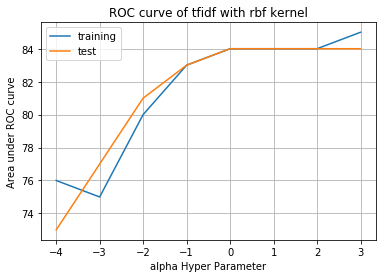

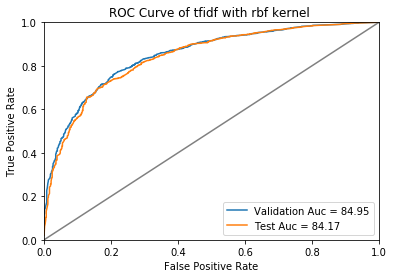

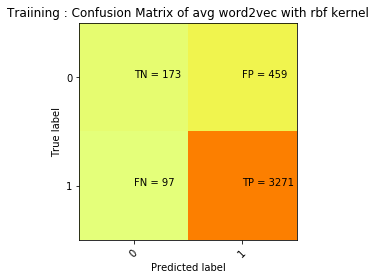

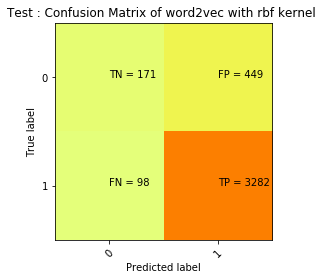

In [81]:
# Please write all the code with proper documentation
def avg_w2v(preprocessed_reviews, x, w2v_model):
    i=0
    list_of_sentance=[]
    for sentance in preprocessed_reviews:
        list_of_sentance.append(sentance.split())
                            
    is_your_ram_gt_16g=False
    want_to_use_google_w2v = False
    want_to_train_w2v = True
    if 1 == x:
        if want_to_train_w2v:
            # min_count = 5 considers only words that occured atleast 5 times
            w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
        elif want_to_use_google_w2v and is_your_ram_gt_16g:
            if os.path.isfile('GoogleNews-vectors-negative300.bin'):
                w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
                print(w2v_model.wv.most_similar('great'))
                print(w2v_model.wv.most_similar('worst'))
        else:
            print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

    w2v_words = list(w2v_model.wv.vocab)                      

    # average Word2Vec
    # compute average word2vec for each review.
    sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in tqdm(list_of_sentance): # for each review/sentence
        sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vectors.append(sent_vec) 
    
    return sent_vectors, list_of_sentance, w2v_model                          


#vectorizing using above function
avg_w2v_x_train, los_train, w2v_model = avg_w2v(x_train, 1, None)
avg_w2v_x_cv, los_cv, w2v_model = avg_w2v(x_cv, 0, w2v_model)
avg_w2v_x_test, los_test, w2v_model = avg_w2v(x_test, 0, w2v_model)



auc_cv = []
auc_test = []
alpha = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
for i in tqdm(alpha):
    # instantiate learning model (k = 30)
    svm = SVC(kernel = "rbf", C = i)
    clfl1    = CalibratedClassifierCV(svm, method='isotonic')

    # fitting the model on crossvalidation train
    clfl1.fit(avg_w2v_x_train, y_train)

    
    y_pred_proba = clfl1.predict_proba(avg_w2v_x_cv)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_cv,  y_pred_proba)
    auc_cv.append(np.round(metrics.roc_auc_score(y_cv, y_pred_proba)*100))
    
    y_pred_proba1 = clfl1.predict_proba(avg_w2v_x_test)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba1)
    auc_test.append(np.round(metrics.roc_auc_score(y_test, y_pred_proba1)*100))
    

    

       
    
    
awr_optimal_alpha = alpha[(auc_cv.index(max(auc_cv)))]



#printing all Auc value of corresponding k on validation and test data
df = pd.DataFrame({
                  'training': auc_cv,
                  'test': auc_test
                  }, index = log_alpha)
lines = df.plot.line()
plt.xlabel("alpha Hyper Parameter")
plt.ylabel("Area under ROC curve")
plt.title("ROC curve of tfidf with rbf kernel")
plt.grid()
plt.show()



svm = SVC(kernel = "rbf", C = awr_optimal_alpha )
clf  = CalibratedClassifierCV(svm, method='isotonic')
clf.fit(avg_w2v_x_train, y_train)



#auc curve of optimal k on validation and test data
y_predk_proba = clf.predict_proba(avg_w2v_x_cv)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_cv,  y_predk_proba)
auc = np.round(metrics.roc_auc_score(y_cv, y_predk_proba)*100, 2)
awr_tr_auc = auc

plt.plot(fpr,tpr,label="Validation Auc = "+str(auc))
y_predk_proba = clf.predict_proba(avg_w2v_x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_predk_proba)
auc = np.round(metrics.roc_auc_score(y_test, y_predk_proba)*100, 2)
awr_ts_auc = auc

plt.plot(fpr,tpr,label="Test Auc = "+str(auc))
plt.legend(loc=4)
plt.plot([x/10 for x in range(0, 11)],[x/10 for x in range(0, 11)], color='grey')
plt.title("ROC Curve of tfidf with rbf kernel ")
plt.axis([0, 1, 0, 1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()



y_pred_test = clf.predict(avg_w2v_x_test)
y_pred_cv = clf.predict(avg_w2v_x_cv)



# http://www.tarekatwan.com/index.php/2017/12/how-to-plot-a-confusion-matrix-in-python/
cm = confusion_matrix(y_cv,y_pred_cv)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['0','1']
plt.title("Traiining : Confusion Matrix of avg word2vec with rbf kernel")
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
 
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()



# http://www.tarekatwan.com/index.php/2017/12/how-to-plot-a-confusion-matrix-in-python/
cm = confusion_matrix(y_test,y_pred_test)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['0','1']
plt.title("Test : Confusion Matrix of word2vec with rbf kernel ")
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
 
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

### [5.2.4]  Applying RBF SVM on TFIDF W2V,<font color='red'> SET 4</font>

In [82]:
# Please write all the code with proper documentation

100%|████████████████████████████████████████████| 8/8 [11:21<00:00, 93.99s/it]


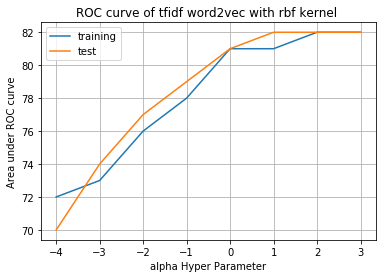

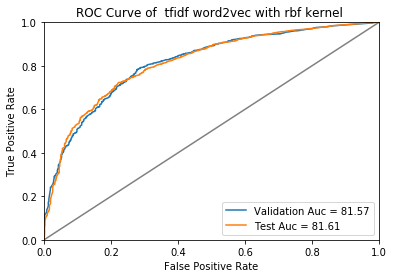

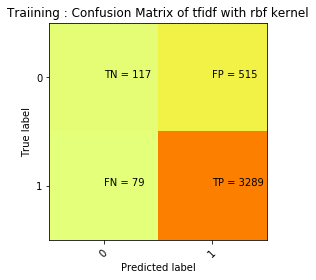

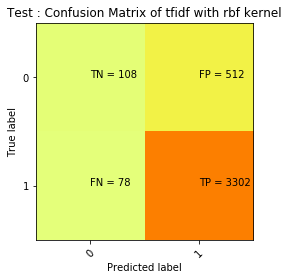

In [83]:
def tfidf_w2v(preprocessed_reviews, list_of_sentance, w2v_model, w2v_words, x, model):
    if 1 == x:
        model = TfidfVectorizer()
        tf_idf_matrix = model.fit_transform(preprocessed_reviews)
        # we are converting a dictionary with word as a key, and the idf as a value
        dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))
        # TF-IDF weighted Word2Vec
        tfidf_feat = model.get_feature_names() # tfidf words/col-names
        # final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf
    else: 
        tf_idf_matrix = model.transform(preprocessed_reviews)
        dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))
        tfidf_feat = model.get_feature_names()
        
    tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
    row=0;
    for sent in tqdm(list_of_sentance): # for each review/sentence 
        sent_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words and word in tfidf_feat:
                vec = w2v_model.wv[word]
                # tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
                # to reduce the computation we are  
                # dictionary[word] = idf value of word in whole courpus
                # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
        row += 1
    return tfidf_sent_vectors, model               


#vectorizing using above function
tfidf_w2v_x_train, model = tfidf_w2v(x_train, los_train, w2v_model, list(w2v_model.wv.vocab), 1, None)
tfidf_w2v_x_cv, model = tfidf_w2v(x_cv, los_cv, w2v_model, list(w2v_model.wv.vocab), 0, model)
tfidf_w2v_x_test, model = tfidf_w2v(x_test, los_test, w2v_model, list(w2v_model.wv.vocab), 0, model)


auc_cv = []
auc_test = []
for i in tqdm(alpha):
    # instantiate learning model (k = 30)
    svm = SVC(kernel = "rbf", C = i)
    clfl1    = CalibratedClassifierCV(svm, method='isotonic')
    # fitting the model on crossvalidation train
    clfl1.fit(tfidf_w2v_x_train, y_train)

    # predict the response on the crossvalidation train
    pred_cv = clfl1.predict(tfidf_w2v_x_train)
    
    y_pred_proba = clfl1.predict_proba(tfidf_w2v_x_cv)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_cv,  y_pred_proba)
    auc_cv.append(np.round(metrics.roc_auc_score(y_cv, y_pred_proba)*100))
    
    y_pred_proba1 = clfl1.predict_proba(tfidf_w2v_x_test)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba1)
    auc_test.append(np.round(metrics.roc_auc_score(y_test, y_pred_proba1)*100))


    
    

twr_optimal_alpha = alpha[(auc_cv.index(max(auc_cv)))]    


#printing all Auc value of corresponding k on validation and test data
df = pd.DataFrame({
                  'training': auc_cv,
                  'test': auc_test
                  }, index = log_alpha)
lines = df.plot.line()
plt.xlabel("alpha Hyper Parameter")
plt.ylabel("Area under ROC curve")
plt.title("ROC curve of tfidf word2vec with rbf kernel ")
plt.grid()
plt.show()


svm = SVC(kernel = "rbf" , C =twr_optimal_alpha )
clf  = CalibratedClassifierCV(svm, method='isotonic')
clf.fit(tfidf_w2v_x_train, y_train)



#auc curve of optimal k on validation and test data
y_predk_proba = clf.predict_proba(tfidf_w2v_x_cv)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_cv,  y_predk_proba)
auc = np.round(metrics.roc_auc_score(y_cv, y_predk_proba)*100, 2)
twr_tr_auc = auc
plt.plot(fpr,tpr,label="Validation Auc = "+str(auc))

y_predk_proba = clf.predict_proba(tfidf_w2v_x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_predk_proba)
auc = np.round(metrics.roc_auc_score(y_test, y_predk_proba)*100, 2)
twr_ts_auc = auc
plt.plot(fpr,tpr,label="Test Auc = "+str(auc))

plt.legend(loc=4)
plt.plot([x/10 for x in range(0, 11)],[x/10 for x in range(0, 11)], color='grey')
plt.title("ROC Curve of  tfidf word2vec with rbf kernel ")
plt.axis([0, 1, 0, 1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()



y_pred_test = clf.predict(tfidf_w2v_x_test)
y_pred_cv = clf.predict(tfidf_w2v_x_cv)



# http://www.tarekatwan.com/index.php/2017/12/how-to-plot-a-confusion-matrix-in-python/
cm = confusion_matrix(y_cv,y_pred_cv)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['0','1']
plt.title("Traiining : Confusion Matrix of tfidf with rbf kernel")
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
 
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()



# http://www.tarekatwan.com/index.php/2017/12/how-to-plot-a-confusion-matrix-in-python/
cm = confusion_matrix(y_test,y_pred_test)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['0','1']
plt.title("Test : Confusion Matrix of tfidf with rbf kernel")
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
 
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

# [6] Conclusions

In [84]:
# Please compare all your models using Prettytable library

In [85]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Model Technique", "Kernel", "alpha or C", "Training Auc", "Test Auc"]

x.add_row(["Bag of words", "Linear", bl_optimal_alpha, bl_tr_auc, bl_ts_auc ])
x.add_row(["Tfidf", "Linear", tl_optimal_alpha, tl_tr_auc, tl_ts_auc])
x.add_row(["Avg Word2vec", "Linear", awl_optimal_alpha, awl_tr_auc, awl_ts_auc])
x.add_row(["Tfidf Word2vec", "Linear", twl_optimal_alpha, twl_tr_auc, twl_ts_auc])
x.add_row(["Bag of words", "RBF", br_optimal_alpha, br_tr_auc, br_ts_auc])
x.add_row(["Tfidf", "RBF", tr_optimal_alpha, tr_tr_auc, tr_ts_auc])
x.add_row(["Avg Word2vec", "RBF", awr_optimal_alpha, awr_tr_auc, awr_ts_auc])
x.add_row(["Tfidf Word2vec", "RBF", twr_optimal_alpha, twr_tr_auc, twr_ts_auc])
print(x)

+-----------------+--------+------------+--------------+----------+
| Model Technique | Kernel | alpha or C | Training Auc | Test Auc |
+-----------------+--------+------------+--------------+----------+
|   Bag of words  | Linear |   0.001    |    94.75     |  94.23   |
|      Tfidf      | Linear |   0.0001   |    95.28     |  94.91   |
|   Avg Word2vec  | Linear |   0.001    |    91.57     |  90.63   |
|  Tfidf Word2vec | Linear |   0.001    |    89.01     |  87.95   |
|   Bag of words  |  RBF   |     10     |    88.15     |  87.18   |
|      Tfidf      |  RBF   |     10     |    92.32     |  90.37   |
|   Avg Word2vec  |  RBF   |    1000    |    84.95     |  84.17   |
|  Tfidf Word2vec |  RBF   |    100     |    81.57     |  81.61   |
+-----------------+--------+------------+--------------+----------+


# Step for alll code:

In [ ]:
Preprocessing of the code:
    1. Importing all important library
    2. Loading data using sqlite3
    3. Making balanced data set
    4. Removing html, punctuation, from text and so on to fit into model
    5. dividing data into 3 part train test cv
Bow and tfidf and avg word2vec and tfidf word2vec with linear kernel:
    1. fitting train to bow model and transforming with train and cv and test
    2. taking  c value from 0.0001 to 1000 with increement  multiple of 10
    3. comparing with l1 and l2 which one goves better accuracy and applied for classifier
    4. ploting all alpha with corresponding with auc so thatcan visualize optimal alpha
    3. finding c optimal 
    4. plotting roc curve of cv and test 
    5. plottinng confusion matrix of cv and test     
Bow and tfidf and avg word2vec and tfidf word2vec with rbf kernel:    
    1. fitting train to bow model and transforming with train and cv and test
    2. taking  c value from 0.0001 to 1000 with increement  multiple of 10 and gamma is auto tuned
    3. ploting all alpha with corresponding with auc so thatcan visualize optimal alpha
    4. finding c optimal 
    5. again fitiing the model with classifier.
    6. plotting roc curve of cv and test 
    7. plottinng confusion matrix of cv and test 